# I) Quick Introduction

What if we can predict the ConfirmedCases and the Fatalities using only one feature? 
What if that feature is just the number of days since the start of pandemic in each single region?

I think that could be possible especially in the short term predictions. 

So to make sure I am not totally wrong, I decided to write this notebook to show a possible model using one feature **NbDay**

** $ ConfirmedCases = γ1 * exp( log(α1) * NbDay ) + β1 $ **

** $ Fatalities = γ2 * exp( log(α2) * NbDay ) + β2 $ **

Where ** $ γ1, α1, β1, γ2, α2, β2 $ ** are all hyperparameters. 

And the **NbDay** repesents the Number of Days since the start of the pandemic in each Country.

We can model assuming that ** $ γ1, α1, β1, γ2, α2, β2 $ ** are the same for all the countries. But that won’t be accurate for many reasons.  In fact not all countries have the same political reaction to this pandemic. And not all countries have the same demographical feautures such as the population, the median age, the density of population. In plus, not all countries have the same economical situation. And many other reasons that justifies that it won’t be possible to have same hyperparameters for all the countries.

We can approximate optimal hyperparameters to model the propagation for each country but the true problem is if all the countries have an exponential growth?! 

Can the exponential model be accurate for all the countries? If not, what are the countries that have an exponential growth? 

Let's read and check!

# II) Preparing the Data

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-global-forecasting-week-4/submission.csv
/kaggle/input/covid19-global-forecasting-week-4/test.csv
/kaggle/input/covid19-global-forecasting-week-4/train.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1) Reading the Data

In [3]:
train = pd.read_csv('../input/covid19-global-forecasting-week-4/train.csv')
test = pd.read_csv('../input/covid19-global-forecasting-week-4/test.csv')

In [4]:
Y1=train['ConfirmedCases']
Y2=train['Fatalities']

## 2) Modifiying date feature

In [5]:
train['Complete_Date'] = train['Date'].astype('datetime64[ns]')
test['Complete_Date'] = test['Date'].astype('datetime64[ns]')

month = [int(el[5:7]) for el in list(train['Date'].values)]
day = [int(el[8:10]) for el in list(train['Date'].values)]

month_test = [int(el[5:7]) for el in list(test['Date'].values)]
day_test = [int(el[8:10]) for el in list(test['Date'].values)]

df_month= pd.DataFrame(month, columns= ['Month'])
df_day= pd.DataFrame(day, columns= ['Day'])

df_month_test= pd.DataFrame(month_test, columns= ['Month'])
df_day_test= pd.DataFrame(day_test, columns= ['Day'])

train=pd.concat([train, df_month], axis=1)
test=pd.concat([test, df_month_test], axis=1)

train=pd.concat([train, df_day], axis=1)
test=pd.concat([test, df_day_test], axis=1)

train['Date']=train['Month']*100+train['Day']
test['Date']=test['Month']*100+test['Day']

## 3) Combining Province_State and Country_Region in one Feature

In [6]:
train['Province_State'].fillna('',inplace=True)
test['Province_State'].fillna('',inplace=True)

train['Province_State']=train['Province_State'].astype(str)
test['Province_State']=test['Province_State'].astype(str)

y= train['Country_Region']+train['Province_State']
y= pd.DataFrame(y, columns= ['Place'])

y_test= test['Country_Region']+test['Province_State']
y_test= pd.DataFrame(y_test, columns= ['Place'])

train=pd.concat([train, y], axis=1)
test=pd.concat([test, y_test], axis=1)

Country_df=train["Place"]
ConfirmedCases_df=train["ConfirmedCases"]
Country_df.to_numpy()
ConfirmedCases_df.to_numpy()
Country=Country_df[0]
NbDay = pd.DataFrame(columns=['NbDay'])
day=0
count=0
for x in train["Month"]:
    if (ConfirmedCases_df[count]==0):      
        NbDay = NbDay.append({'NbDay': int(0)}, ignore_index=True)
        count=count+1 
    else:
        if (Country_df[count]==Country):
            day=day+1
            NbDay = NbDay.append({'NbDay': int(day)}, ignore_index=True)
            count=count+1
        else:
            Country=Country_df[count]
            day=1
            NbDay = NbDay.append({'NbDay': int(day)}, ignore_index=True)
            count=count+1
train=pd.concat([train, NbDay], axis=1)

## 4) Making a new features counting days since the starting of the pandemic for each country

In [7]:
# Adding NbDay feature to the test data
NbDay_test_array=np.zeros(test.shape[0])
i=0
df=test["Place"]
Place_array=df.to_numpy()
for t in test.Date:
    place=Place_array[i]
    if t==402:
        row=train.loc[(train['Place'] == place) & (train['Date'] ==t)]
        row=row.to_numpy()
        NbDay_test_array[i]= row[0][10]
    else: 
        NbDay_test_array[i]=0
    i=i+1

NbDay=pd.DataFrame(NbDay_test_array, columns=['NbDay1'])
test=pd.concat([test,NbDay], axis=1)

Country_df=test["Place"]
NbDay_df=test['NbDay1']
Country_df.to_numpy()
day_array=NbDay_df.to_numpy()
Country=Country_df[0]
NbDay = pd.DataFrame(columns=['NbDay'])
day=0
count=0
for t in test["Date"]:
    if (t==402):
        day=day_array[count] 
        NbDay = NbDay.append({'NbDay': int(day)}, ignore_index=True)  
        count=count+1
    else:
        day=day+1
        NbDay = NbDay.append({'NbDay': int(day)}, ignore_index=True)
        count=count+1
test=pd.concat([test,NbDay], axis=1)

## 5) Taking the essential features for the next steps

In [8]:
train=train[['Place','NbDay','ConfirmedCases','Fatalities']]
test=test[['Place','NbDay']]

# III) Warm-up: Checking the exponential shape in my homecountry

In [9]:
def plot_xy(column1,column2):
    x=column1.to_numpy()
    y=column2.to_numpy()
    
    f, ax = plt.subplots(figsize=(15,10))
    plt.plot(x,y)

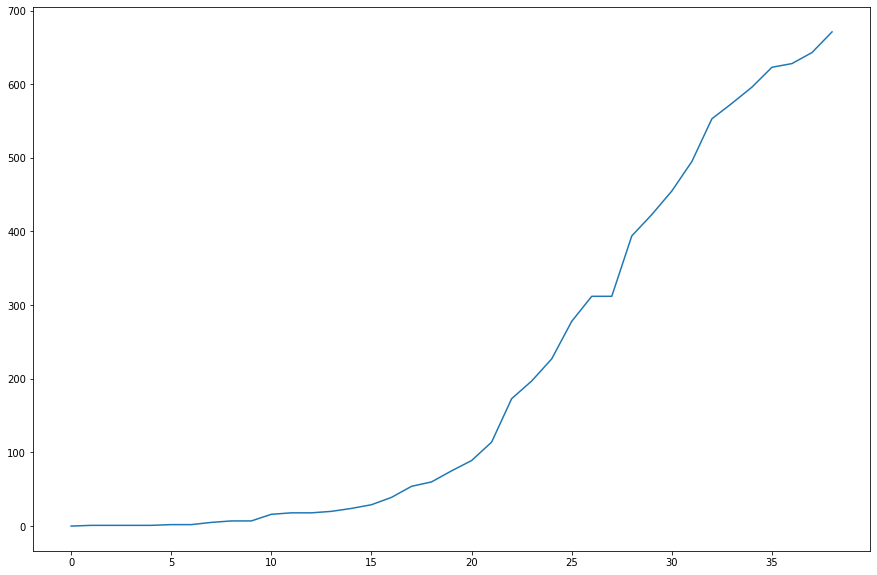

In [10]:
plot_xy(train[train['Place']=='Tunisia']['NbDay'],train[train['Place']=='Tunisia']['ConfirmedCases'])

In [11]:
train_data = train
test_data = test

# IV) Finding best hyperparameters: alphas to fit the exponential forecasting and Classifiying Countries based on their pandemic growth

## 1) Creating a list of all the regions 

In [12]:
train_data.columns

Index(['Place', 'NbDay', 'ConfirmedCases', 'Fatalities'], dtype='object')

In [13]:
country_array=train_data['Place'].to_numpy()

In [14]:
country_array

array(['Afghanistan', 'Afghanistan', 'Afghanistan', ..., 'Zimbabwe',
       'Zimbabwe', 'Zimbabwe'], dtype=object)

In [15]:
def distinct_values(country_array):
    liste=[]
    liste.append(country_array[0])
    for i in range(1,len(country_array)): 
        if country_array[i]!=country_array[i-1]:
            liste.append(country_array[i])
    return liste

In [16]:
Countries_liste=distinct_values(country_array)

In [17]:
len(Countries_liste)

313

## 2) Finding best alpha1 for each country

In [18]:
def exponentiate_alpha(column,v):

    
    array=column.to_numpy()
    
    string='NbDay'+str(v)
    
    array=np.power(v,array)
        
    frame=pd.DataFrame(array, columns=[string])
    
        
    return frame

In [19]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

liste_mse_countries=[]
liste_r2_countries=[]
results=[]

i=1
for country in Countries_liste:
    
    
    train_NbDay=train[train['Place']==country]['NbDay']
    y_NbDay=train[train['Place']==country]['ConfirmedCases']
    
    test_NbDay=test[test['Place']==country]['NbDay']
    
    #alpha=[1+i*0.0001 for i in range(1,6001)]
    alpha=[1+i*0.01 for i in range(1,101)]

    liste_mse_countries=[]
    liste_r2_countries=[]
    liste_mse=[]
    liste_r2=[]
    liste_rmsle=[]
    
    print('For country ',i,': *******************', country, '')
    
    i=i+1
    
    for v in alpha: 
    
        
        X1=exponentiate_alpha(train_NbDay,v)
    
        
        X_train,X_test,y_train,y_test = train_test_split(X1,y_NbDay,test_size = 0.3, shuffle= False)
    
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        y_pred = np.maximum(y_pred, 0)
    
        #print('For alpha =',v)
        # The coefficients
        #print('Coefficients: \n', regr.coef_)
        # The mean squared error
        #print('Mean squared error: %.2f'
        # % mean_squared_error(y_test, y_pred))
        #liste_mse.append(mean_squared_error(y_test, y_pred))
        liste_rmsle.append(np.sqrt(mean_squared_log_error( y_test, y_pred )))
        
        # The coefficient of determination: 1 is perfect prediction
        #print('Coefficient of determination: %.2f'
        #  % r2_score(y_test, y_pred))
        liste_r2.append(r2_score(y_test, y_pred))

        #print('***********************************************************************')
    
    #argminimum = np.argmin(liste_mse)
    #argminimum = np.argmin(liste_rmsle)
    argmaximum = np.argmax(liste_r2)
    
    maximum = liste_r2[argmaximum]
    #minimummse = liste_mse[argmaximum]
    minimum = liste_rmsle[argmaximum]
    
    #liste_mse_countries.append((minimum,argminimum))
    #liste_r2_countries.append((maximum,argmaximum))
    
    results.append([country,maximum,minimum,alpha[argmaximum]])
    print('Best R2=', maximum, 'where alpha=', alpha[argmaximum])
    print('where RMLSE=', minimum)
    #print('where MSE=', minimummse)
    #print('Best MSE=', minimum, 'where alpha=', alpha[argminimum])
    print('___________________________________________')

For country  1 : ******************* Afghanistan 
Best R2= 0.9450288673220729 where alpha= 1.15
where RMLSE= 0.21570757213073122
___________________________________________
For country  2 : ******************* Albania 
Best R2= 0.9644319753635124 where alpha= 1.06
where RMLSE= 0.10389089910728266
___________________________________________
For country  3 : ******************* Algeria 
Best R2= 0.8673863430556374 where alpha= 1.16
where RMLSE= 0.3023865109912443
___________________________________________
For country  4 : ******************* Andorra 
Best R2= 0.2992776248490576 where alpha= 1.18
where RMLSE= 0.8741989638091846
___________________________________________
For country  5 : ******************* Angola 
Best R2= -1.5762711864406778 where alpha= 1.01
where RMLSE= 2.0503496524866645
___________________________________________
For country  6 : ******************* Antigua and Barbuda 
Best R2= 0.9326936551128305 where alpha= 1.07
where RMLSE= 0.3013040124574285
__________________

## 3) Classfiying Places in two groups: Countries with clear ConfirmedCases exponential growth & Countries not showing clear exponential growth

In [20]:
exponential_countries=[]
non_exponential_countries=[]

for liste in results: 
    if liste[1]<0.80 and liste[2]>0.2 : 
        non_exponential_countries.append(liste[0])
    else : 
        exponential_countries.append((liste[0],liste[3]))

In [21]:
print('Number of regions where we can fit an exponential ConfirmedCases model is:',len(exponential_countries),'among a total of:',len(Countries_liste),'.')

Number of regions where we can fit an exponential ConfirmedCases model is: 128 among a total of: 313 .


## 4) Finding best alpha2 for each country and Classifiying countries

In [22]:
liste_mse_countries=[]
liste_r2_countries=[]
results2=[]

i=1
for country in Countries_liste:
    
    
    train_NbDay=train[train['Place']==country]['NbDay']
    y_NbDay=train[train['Place']==country]['Fatalities']
    
    test_NbDay=test[test['Place']==country]['NbDay']
    
    #alpha=[1+i*0.0001 for i in range(1,6001)]
    alpha=[1+i*0.01 for i in range(1,101)]

    liste_mse_countries=[]
    liste_r2_countries=[]
    liste_mse=[]
    liste_r2=[]
    liste_rmsle=[]
    
    print('For country ',i,': *******************', country, '')
    
    i=i+1
    
    for v in alpha: 
    
        
        X1=exponentiate_alpha(train_NbDay,v)
    
        
        X_train,X_test,y_train,y_test = train_test_split(X1,y_NbDay,test_size = 0.3, shuffle= False)
    
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        y_pred = np.maximum(y_pred, 0)
    
        #print('For alpha =',v)
        # The coefficients
        #print('Coefficients: \n', regr.coef_)
        # The mean squared error
        #print('Mean squared error: %.2f'
        # % mean_squared_error(y_test, y_pred))
        #liste_mse.append(mean_squared_error(y_test, y_pred))
        liste_rmsle.append(np.sqrt(mean_squared_log_error( y_test, y_pred )))
        
        # The coefficient of determination: 1 is perfect prediction
        #print('Coefficient of determination: %.2f'
        #  % r2_score(y_test, y_pred))
        liste_r2.append(r2_score(y_test, y_pred))

        #print('***********************************************************************')
    
    #argminimum = np.argmin(liste_mse)
    #argminimum = np.argmin(liste_rmsle)
    argmaximum = np.argmax(liste_r2)
    
    maximum = liste_r2[argmaximum]
    #minimummse = liste_mse[argmaximum]
    minimum = liste_rmsle[argmaximum]
    
    #liste_mse_countries.append((minimum,argminimum))
    #liste_r2_countries.append((maximum,argmaximum))
    
    results2.append([country,maximum,minimum,alpha[argmaximum]])
    print('Best R2=', maximum, 'where alpha=', alpha[argmaximum])
    print('where RMLSE=', minimum)
    #print('where MSE=', minimummse)
    #print('Best MSE=', minimum, 'where alpha=', alpha[argminimum])
    print('___________________________________________')

For country  1 : ******************* Afghanistan 
Best R2= -1.1990632318501167 where alpha= 1.01
where RMLSE= 1.7466391169217899
___________________________________________
For country  2 : ******************* Albania 
Best R2= 0.8392870844538058 where alpha= 1.11
where RMLSE= 0.24296030472228014
___________________________________________
For country  3 : ******************* Algeria 
Best R2= 0.9628931472059583 where alpha= 1.19
where RMLSE= 0.24783169405932726
___________________________________________
For country  4 : ******************* Andorra 
Best R2= -1.160720240080027 where alpha= 1.01
where RMLSE= 2.178646891060257
___________________________________________
For country  5 : ******************* Angola 
Best R2= -1.1818181818181817 where alpha= 1.01
where RMLSE= 0.8085567515271568
___________________________________________
For country  6 : ******************* Antigua and Barbuda 
Best R2= -0.18631178707224327 where alpha= 1.01
where RMLSE= 0.4133854081622836
________________

## 5) Classfiying Places in two groups: Countries with clear Fatalities exponential growth & Countries not showing clear exponential growth

In [23]:
exponential_countries=[]
non_exponential_countries=[]

for liste in results2: 
    if liste[1]<0.80 and liste[2]>0.2 : 
        non_exponential_countries.append(liste[0])
    else : 
        exponential_countries.append((liste[0],liste[3]))

In [24]:
print('Number of regions where we can fit an exponential ConfirmedCases model is:',len(exponential_countries),'among a total of:',len(Countries_liste),'.')

Number of regions where we can fit an exponential ConfirmedCases model is: 116 among a total of: 313 .


# V) Conclusion

$1$) Almost one half of the countries show an exponential growth of confirmedcases and fatalities.

$2$) We can safely model the ConfirmedCases growth with an exponential model for $128$ region and having an $R2$ score higher than $0.8$ and an $RMSLE$ score lower than $0.2$ .

$3$) We can safely model the Fatalities growth with an exponential model for $116$ region and having an $R2$ score higher than $0.8$ and an RMSLE score lower than $0.2$ .

$4$) It is true that this model shows good $R2$ and $RMSLE$ scores for the predictions of half of the regions. However we are aware that its predictions are reliable only on the short term because in the long term we are totally aware that the growth will slow down in all the countries sooner or later so the exponential modeling won't resist in the long term predictions.